## Packages & Libraries

In [ ]:
import os
import skimage
from skimage import transform
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow import keras
from keras import layers
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Split Data Folders

from each folders we split:
* 80% for training
* 10% for testing
*10% for validation

In [ ]:
import splitfolders
IMG_HEIGHT = 128
IMG_WIDTH = 128

input_folder='/content/drive/MyDrive/Kaggle/Alzheimer_data/Dataset'

output_folder='/content/drive/MyDrive/datasplitted'

train_ratio=0.8
validation_ratio=0.1
test_ratio=0.1
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


#ImageDataGenerator for image augmentation and preprocessing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE=16
IMG_SIZE=(128,128)
SEED=1345

train_datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0,
                                zoom_range=0.2)

validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = '/content/drive/MyDrive/datasplitted/train'
validation_dir = '/content/drive/MyDrive/datasplitted/val'
test_dir = '/content/drive/MyDrive/datasplitted/test'

In [ ]:

#Defining generatores for train,validation,test

train_generator=train_datagen.flow_from_directory(
    train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,

    class_mode ='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical',)

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical',
)

In [ ]:
class_names=list(train_generator.class_indices.keys())
print(class_names)

In [ ]:
plt.figure(figsize=(12,12))

for images,labels in train_generator:
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        print(images[i].shape)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

## Create Model
* Create architecture

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

* Compile

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy",tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])

In [ ]:
model.summary()


In [ ]:
input_folder='/content/drive/MyDrive/Kaggle/Alzheimer_data/Dataset'

class_count=dict()

for i in class_names:
    class_count[i]=len(os.listdir(input_folder+'/'+i))

plt.figure(figsize=(10,4))
colors = ['red', 'blue', 'green', 'orange']
plt.bar(class_count.keys(),class_count.values(),color=colors)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Visualization of Data Imbalance')
plt.grid(True)
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)

In [ ]:
! pip install visualkeras

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [ ]:
#@title Default title text
history=model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator),
                        epochs = 100,
                        verbose = 1)

In [ ]:
model.save("my_h5_model.h5")

In [ ]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

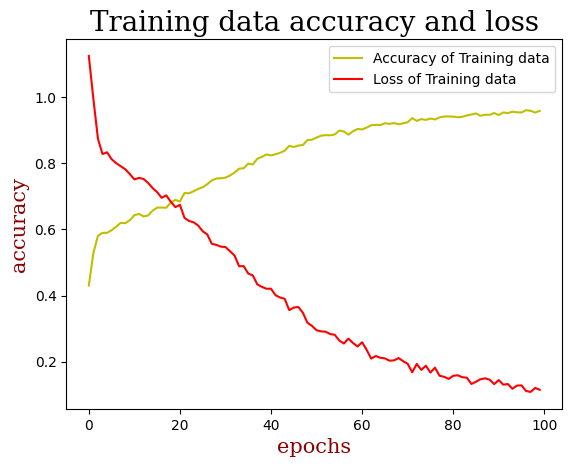

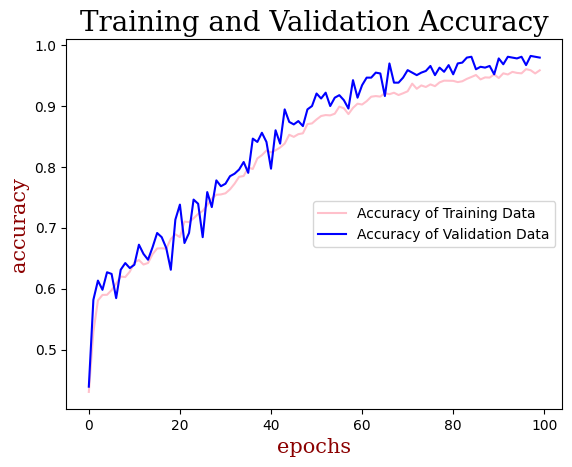

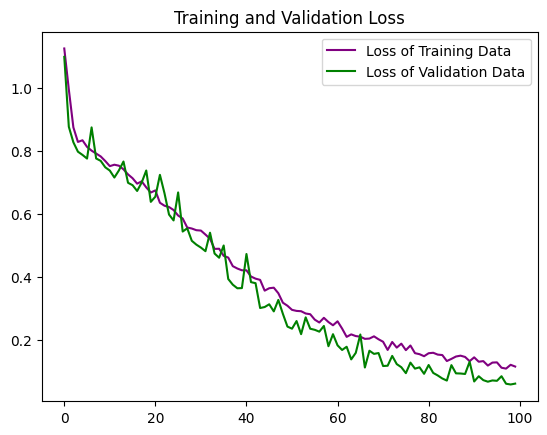

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))


#plt.plot(2 ,3,1)
plt.plot(epochs, get_ac, 'y', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')

font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

plt.title("Training data accuracy and loss", fontdict = font1)
plt.xlabel("epochs", fontdict = font2)
plt.ylabel("accuracy", fontdict = font2)

plt.legend(loc=1)
plt.figure()

#plt.subplot( 2 , 3, 2)
plt.plot(epochs, get_ac, 'pink', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'b', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy',fontdict = font1)
plt.xlabel("epochs", fontdict = font2)
plt.ylabel("accuracy", fontdict = font2)
plt.legend(loc='right')
plt.figure()


#plt.subplot(2 , 3, 3)
plt.plot(epochs, get_los, 'purple', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'g', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=1)
plt.figure()
plt.show()


* Evaluate Model

In [ ]:
loss ,  accuracy = model.evaluate(test_generator)

* Predict Model

In [ ]:
Y_pred=model.predict(test_generator)

12/12 [==============================] - 9s 783ms/step


In [ ]:
test_label=test_generator.classes

In [ ]:
y_pred=np.array(y_pred)
y_pred.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
  if normalize:
    title = "Normalized Confusion Matrix"
  else:
      title = "Confusion Matrix"



plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

fmt = 'd'
#     '.2f' if normalize else
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
  plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

cm = confusion_matrix(test_label, y_pred)

class_names

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()

In [ ]:
from keras.backend import in_test_phase
plt.figure(figsize=(20, 20))
images,labels=test_generator.next()
for image, label in zip(images,labels):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

In [ ]:
import cv2
img = cv2.imread("/content/drive/MyDrive/Kaggle/Alzheimer_data/Dataset/Moderate_Demented/moderate_6.jpg", cv2.IMREAD_COLOR)

In [ ]:
img= cv2.resize(img, (128, 128),interpolation = cv2.INTER_AREA)
img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
img = img/255.

In [ ]:
model.predict(img)

1/1 [==============================] - 0s 20ms/step
array([[0.16600822, 0.18584388, 0.2728341 , 0.3753138 ]], dtype=float32)